### Pitanja za konsultacije

1. Zbog cega ZCR za neke signale (snimljene kvalitetnijim mikrofonom) uopste nema smisla?
2. Da li je u redu da za potrebe diplomskog moji ulazni audio snimci budu reci, izgovarane sa velikom pauzom izmedju istih? Ili da bar inicijalno radim sa ovakvim dataset-om, a posle pokusam da primenim isto na realisticnije podatke?
3. Da li koristiti samo MFCC ili kombinovati jos neku metodu za izvlacenje pitch periode (autokorelacionu recimo)?
4. Neka ideja je da prvo probam sa nekim jednostavnijim ML modelom, recimo KNN. Pa ako to ne uspe da se oprobam sa neuralnom mrezom.

5. Kada je u pitanju segmentiranje reci pragovi za ZCR i STE su poprilicno osetljivi i potrebno ih je cesto rucno prilagodjavati. U nekoj realistcnoj primeni ovakvog modela da li bi bilo bolje samo potpuno izbeci segmentiranje reci? Mozda koristiti neki inicijalni model za prepoznavanje da uopste postoji govor, i onda radi ekstrakciju pitch periode iz cele govorne sekvence?

In [15]:
%matplotlib widget
from scipy.io import wavfile
from librosa import load
from scipy.signal import butter, lfilter
import numpy as np
import os
import matplotlib.pyplot as plt

In [7]:
working_dir = os.getcwd()

### Visualization of signal

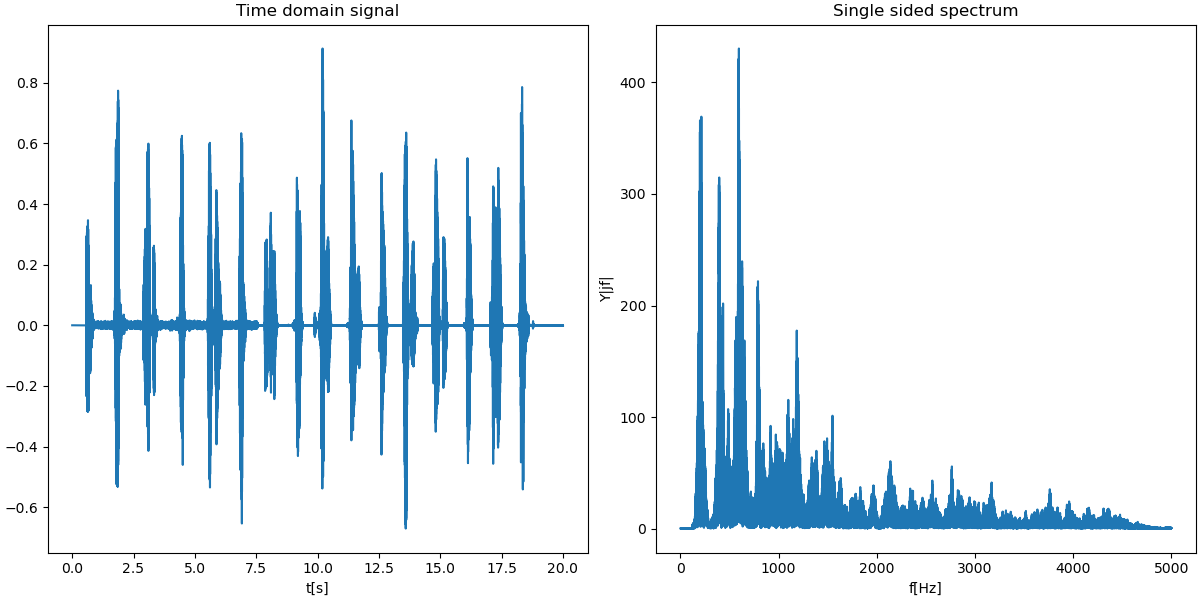

In [16]:
#fs, y = wavfile.read(os.path.join(working_dir, '..', 'Data', 'initial_sample', 'milica_sample_1.wav'))
y, fs = load(os.path.join(working_dir, '..', 'Data', 'initial_sample', 'milica_sample_1.wav'), sr=None)
duration = len(y)/fs
N = len(y)
t = np.linspace(0,duration,N)

Y = abs(np.fft.fft(y,N))
Y = Y[0:N//2]
f = np.fft.fftfreq(n = N, d = 1/fs)
f = f[0:N//2]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6),
                       layout='constrained')
axs = ax.ravel()
axs[0].plot(t,y)
axs[0].title.set_text('Time domain signal')
axs[0].set_xlabel('t[s]')
axs[1].plot(f,Y)
axs[1].title.set_text('Single sided spectrum')
axs[1].set_xlabel('f[Hz]')
axs[1].set_ylabel('Y|jf|')

plt.show()


### Filtering

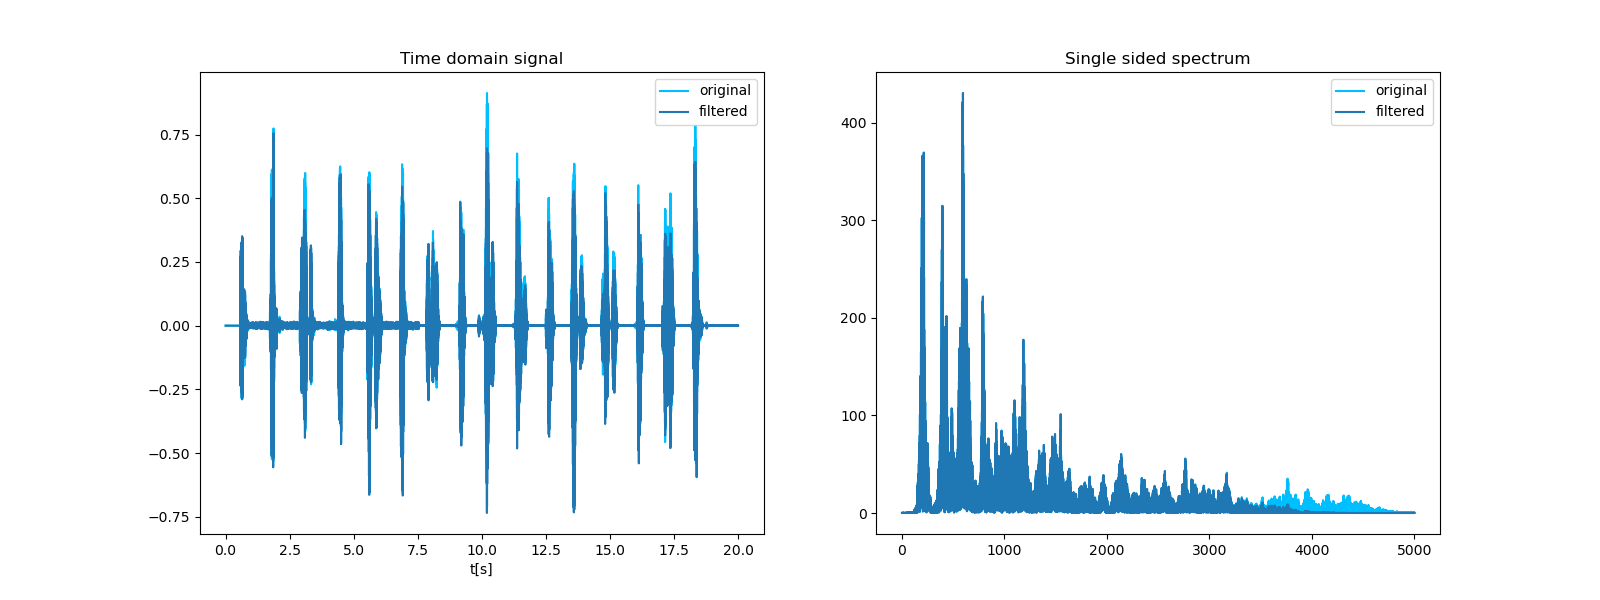

In [17]:
Wn = np.array([50/(fs/2), 3500/(fs/2)])
B,A = butter(6, Wn, btype='bandpass')
yf = lfilter(B,A,y)

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(t,y,color='deepskyblue', label='original')
plt.plot(t, yf, label='filtered')
plt.title('Time domain signal')
plt.xlabel('t[s]')
plt.legend()

Yf = abs(np.fft.fft(yf,N))
Yf = Yf[0:N//2]

plt.subplot(122)
plt.plot(f,Y, color = 'deepskyblue', label='original')
plt.plot(f,Yf,label='filtered')
plt.title('Single sided spectrum')
plt.legend()
plt.show()

### Choosing a window function

In [10]:
wl = np.array(np.multiply([1e-3,10e-3, 20e-3, 50e-3],fs), dtype=int)

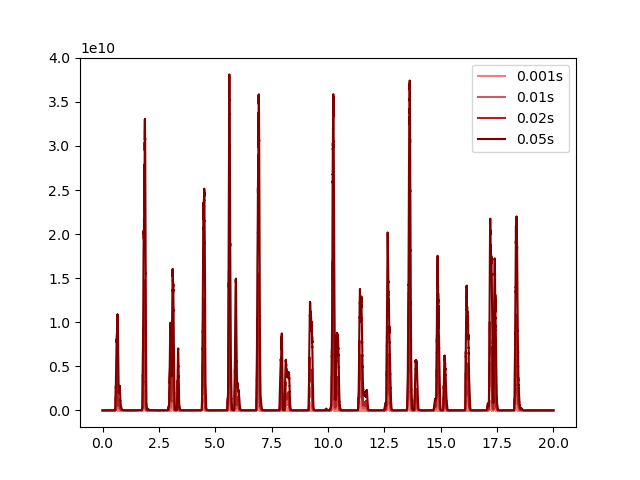

In [11]:
colors = ['lightcoral', 'indianred', 'firebrick', 'maroon']
fig,ax = plt.subplots()
for i in range(len(wl)):
    E = np.zeros(len(yf))
    for k in range(i,len(yf)):
        rng = np.arange((k-wl[i]),k)
        E[k] = np.sum(np.power(yf[rng],2))
    time = np.arange(0,E.shape[0]/fs,1/fs)
    ax.plot(time,E, color=colors[i],label=str(wl[i]/fs)+'s')
ax.legend()

### Short time energy and zero crossing rate with 20ms window

In [18]:
wl = int(fs*20e-3)
E = np.zeros(len(yf))
ZCR = np.zeros(len(yf))

for i in range(wl, len(yf)):
    rng = np.arange(i-wl, i)
    E[i] = np.sum(np.power(yf[rng],2))
    ZCR[i] = np.sum(np.abs(np.sign(yf[rng+1])-np.sign(yf[rng])))

ZCR = ZCR/2/wl

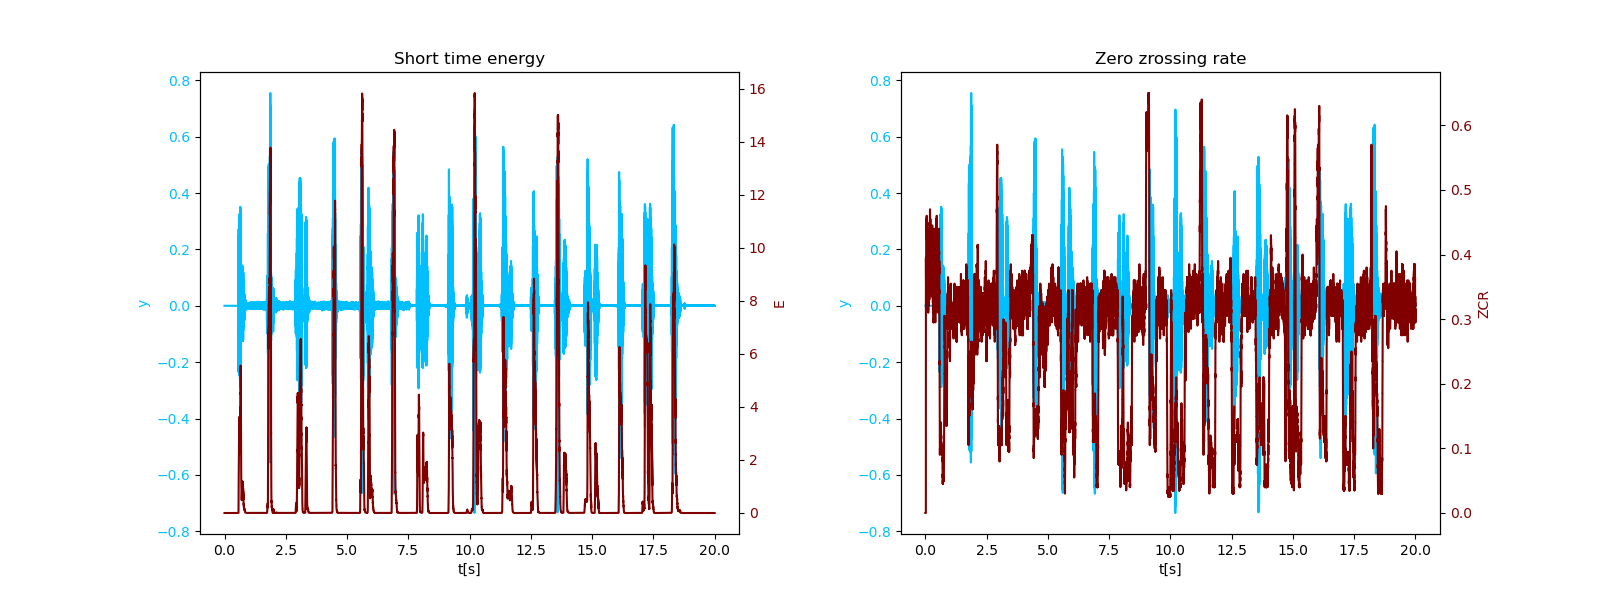

In [19]:
fig,(axs_left_1, axs_left_2) = plt.subplots(nrows=1,ncols=2,figsize=(16,6))
plt.subplots_adjust(wspace=0.3)

axs_left_1.title.set_text('Short time energy')
axs_left_1.plot(time, yf, color = 'deepskyblue')
axs_left_1.set_ylabel('y', color='deepskyblue')
axs_left_1.set_xlabel('t[s]')
axs_left_1.tick_params(axis='y', labelcolor='deepskyblue')


axs_right_1 = axs_left_1.twinx()
axs_right_1.set_ylabel('E', color='maroon')
axs_right_1.plot(time,E, color='maroon')
axs_right_1.tick_params(axis='y', labelcolor='maroon')

axs_left_2.title.set_text('Zero zrossing rate')
axs_left_2.plot(time, yf, color = 'deepskyblue')
axs_left_2.set_ylabel('y', color='deepskyblue')
axs_left_2.set_xlabel('t[s]')
axs_left_2.tick_params(axis='y', labelcolor='deepskyblue')


axs_right_2 = axs_left_2.twinx()
axs_right_2.set_ylabel('ZCR', color='maroon')
axs_right_2.plot(time,ZCR, color='maroon')
axs_right_2.tick_params(axis='y', labelcolor='maroon')

plt.show()

### Word segmentation

#### Short time energy

In [53]:
ITU = 0.1*np.max(E)
ITL = 0.0002*max(E)

##### Finding begginings and ends of words with upper threshold

In [54]:
word_beginning = []
word_end = []

for i in range(1, E.shape[0]):
    if (E[i-1] < ITU) and (E[i] >= ITU):
        word_beginning.append(i)
    elif (E[i-1] > ITU) and (E[i] <= ITU):
        word_end.append(i)


In [55]:
word = np.zeros(shape = E.shape)
for i in range(len(word_beginning)):
    word[word_beginning[i]:word_end[i]] = max(E)/3*np.ones(word_end[i]-word_beginning[i])

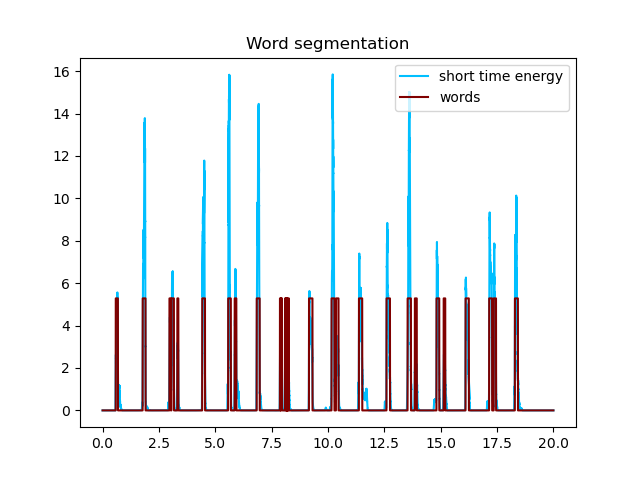

In [56]:
fig = plt.figure()
plt.title("Word segmentation")
plt.plot(time, E, color='deepskyblue', label="short time energy")
plt.plot(time, word, color='maroon', label='words')
plt.legend()
plt.show()

##### Refining our search with lower threshold

In [57]:
for i in range(len(word_beginning)):
    new_beginning = word_beginning[i]
    while(E[new_beginning] > ITL):
        new_beginning -= 1
    word_beginning[i] = new_beginning

for i in range(len(word_end)):
    new_end = word_end[i]
    while(E[new_end] > ITL):
        new_end += 1
    word_end[i] = new_end

In [60]:
word = np.zeros(shape = E.shape)
longest_word_len = 0
for i in range(len(word_beginning)):
    word[word_beginning[i]:word_end[i]] = max(E)/3*np.ones(word_end[i]-word_beginning[i])
    if (word_end[i]-word_beginning[i]) >  longest_word_len:
        longest_word_len = word_end[i]-word_beginning[i]

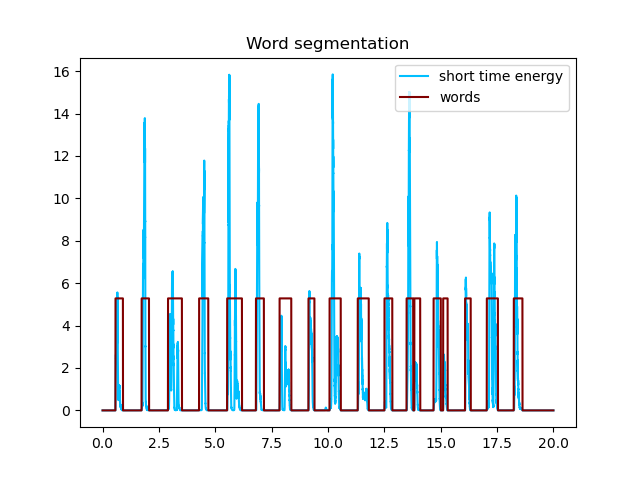

In [59]:
fig = plt.figure()
plt.title("Word segmentation")
plt.plot(time, E, color='deepskyblue', label="short time energy")
plt.plot(time, word, color='maroon', label='words')
plt.legend()
plt.show()

#### Zero crossing rate

In [ ]:
IZCT = 60
frames = 25
threshold = 3

In [64]:
word_matrix = np.zeros(shape = (len(word_beginning), longest_word_len))
for i in range(len(word_beginning)):
    word_matrix[i, 0:(word_end[i]-word_beginning[i])] = yf[word_beginning[i]:word_end[i]]